<a href="https://colab.research.google.com/github/IpastorSan/seq2seq-with-attention-OCR-translation/blob/fix_inference/model/vanilla_seq2seq/vanilla_seq2seq_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


#1)Relevant Imports

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import GRU, LSTM, Input, Dense, Embedding, Bidirectional, Concatenate
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
from gensim.models import Word2Vec, KeyedVectors
from nltk.translate.bleu_score import corpus_bleu
import pandas as pd
import matplotlib.pyplot as plt
import os, datetime

In [3]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [4]:
######Data Preparation#######

def open_data(dataset, num_examples=None):
    with open(dataset) as archivo:
        datos = [line.rstrip('\n') for line in archivo]
        corpus = datos[:num_examples]

    return corpus


# Corpus. Adapt the path to your directory
num_examples = 20000
corpus_zh = open_data("/content/gdrive/My Drive/tfm/dataset_zh.txt", num_examples=num_examples)
corpus_en = open_data("/content/gdrive/My Drive/tfm/dataset_en.txt", num_examples=num_examples)


#2)Maximum length, Tokenizer, Pretrained, embeddings and batch generator

##2.1)max len

In [5]:
def max_len(data):
    return max(len(line.split()) for line in data)

# Set max len
zh_max_len = max_len(corpus_zh)
en_max_len = max_len(corpus_en)
global_max_len = max(en_max_len, zh_max_len)  #This helps us when training the model, setting all lengths to the maximum

##2.2 Tokenizer

In [6]:
def tokenizer(dataset, max_len, max_features, language="en"):
    tokenizer_lang = Tokenizer(num_words=max_features, filters="")

    tokenizer_lang.fit_on_texts(dataset)

    word_tensor = tokenizer_lang.texts_to_sequences(dataset)
    word_tensor = tf.keras.preprocessing.sequence.pad_sequences(word_tensor,maxlen=max_len, padding="post")

    return tokenizer_lang, word_tensor  #dictionary with tokenized words/sequences translated to numbers

# Tokenizacion. We obtain tokenizer and sequences
zh_tokenizer_lang, zh_word_tensor = tokenizer(corpus_zh, global_max_len, max_features=5381)
en_tokenizer_lang, en_word_tensor = tokenizer(corpus_en, global_max_len, max_features=5381)

In [7]:
# Length of each set of vocabulary
zh_vocab_size = len(zh_tokenizer_lang.word_index)
en_vocab_size = len(en_tokenizer_lang.word_index)

##2.3 Embeddings

In [9]:
#Preparation of embedding files.
#Source Chinese Embedding: https://github.com/Kyubyong/wordvectors
#Source English Embedding: https://fasttext.cc/docs/en/english-vectors.html
#All embeddings come from word2vec models

embedding_file_en = "/content/gdrive/My Drive/tfm/en.bin"
embedding_file_zh = "/content/gdrive/My Drive/tfm/zh.bin"


def from_w2v_to_dict(embedding_file, lang="zh"):
    if lang == "en":
        model = KeyedVectors.load_word2vec_format(embedding_file, binary=True)
    else:
        model = Word2Vec.load(embedding_file)

    vector = model.wv.vectors
    words = model.wv.index2word
    union_embeddings = dict(zip(words, vector))
    return union_embeddings

In [10]:
embedding_zh = from_w2v_to_dict(embedding_file_zh)
embedding_en = from_w2v_to_dict(embedding_file_en, lang="en")

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:254: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).


In [11]:
#Extract embedding weights to input into Keras Embedding Layer. Words not found in the embedding
#will be substitued with a random vector with normal distribution with mean=embedding mean and std=embedding std


def get_embedding_weights(embedd_dict, tokenizer_index, max_features=1000):
    embed = list(embedd_dict.values())

    all_embs = np.stack(embed)
    emb_mean, emb_std = all_embs.mean(), all_embs.std()
    embed_size = all_embs.shape[1]  # probar

    word_index = tokenizer_index.word_index
    nb_words = len(word_index)

    embedding_matrix = np.random.normal(emb_mean, emb_std, \
                                        size=(nb_words, embed_size))

    for word, i in word_index.items():
        if i >= max_features:
            continue
        embedding_vector = np.array(embedd_dict.get(word))
        if embedding_vector.size is not 1:
            embedding_matrix[i] = embedding_vector

    return embedding_matrix

In [46]:
emb_zh = get_embedding_weights(embedding_zh, zh_tokenizer_lang, max_features=zh_vocab_size)
emb_en = get_embedding_weights(embedding_en, en_tokenizer_lang, max_features=en_vocab_size)

##2.4 Batch Generator

In [13]:
########Batch Generator for training. We also implement teacher forcing here######
#252 is hardcoded here, is intended to be the batch size of the generator
def generate_batch():
    while True:
        for j in range(0, len(zh_word_tensor)):
            encoder_input_data = np.zeros((global_max_len), dtype='float32')
            decoder_input_data = np.zeros((global_max_len), dtype='float32')
            decoder_target_data = np.zeros((global_max_len, en_vocab_size), dtype='float32')
            for i, (input_text, target_text) in enumerate(zip(zh_word_tensor[j:j+1],en_word_tensor[j:j+1])):
                for t, word in enumerate(input_text):
                  encoder_input_data[t] = word  # encoder input seq
                for t, word in enumerate(target_text):
                    if t < len(target_text) - 1:
                       decoder_input_data[t] = word  # decoder input seq
                    if t > 0:
                        # decoder target sequence (one hot encoded)
                        # does not include the "start" token and is offset by one timestep
                        decoder_target_data[t - 1, word] = 1  # si el vector es (1, 2, 4) ese 4 es 0001
            yield ((encoder_input_data, decoder_input_data), decoder_target_data)

types = ((tf.float32,\
         tf.float32),\
         tf.float32)           
shapes=((tf.TensorShape([global_max_len]),tf.TensorShape([global_max_len])),
        tf.TensorShape([None,en_vocab_size,]))
dataset = tf.data.Dataset.from_generator(generate_batch, types, shapes)

In [14]:
batch_size = 256
train=int(len(en_word_tensor)*0.8)
test=int(len(en_word_tensor)*0.2)
dataset=dataset.shuffle(1000, reshuffle_each_iteration=False)
dataset_train = dataset.skip(test).batch(batch_size, drop_remainder=True)
dataset_test = dataset.take(test).batch(batch_size, drop_remainder=True)

#3) Encoder-Decoder for training

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 17)]         0                                            
__________________________________________________________________________________________________
decoder_input (InputLayer)      [(None, 17)]         0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 17, 300)      3168600     input_2[0][0]                    
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 17, 300)      1614300     decoder_input[0][0]              
_______________________________________________________________________________________

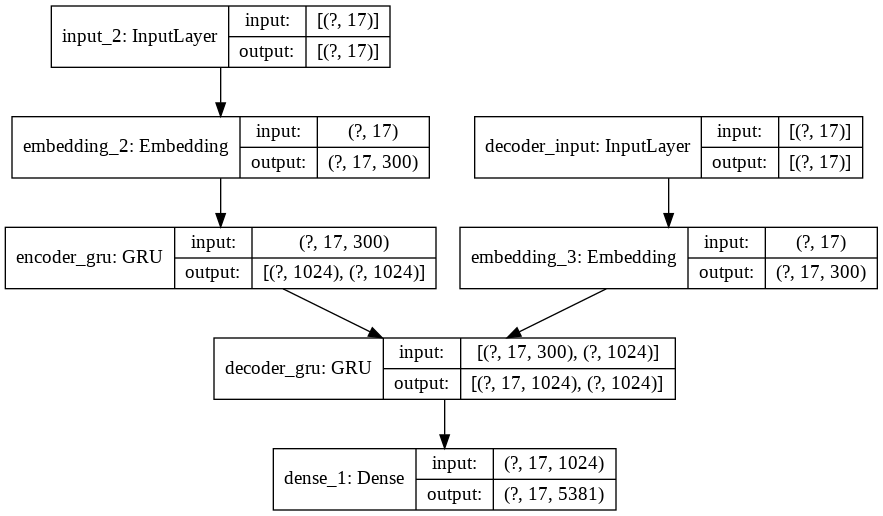

In [18]:
###########Model for training. GRU units, without Attention#########

#Model seq2seq
nodes = 1024
learning_rate = 0.01 
clip_value = 1

# encoder-Chinese
encoder_input = Input(shape=(global_max_len,))
#mask_zero=True allows for the padding 0 at the end of the sequence to be ignored
encoder_embedding = Embedding(input_dim=zh_vocab_size, output_dim=300, weights=[emb_zh], mask_zero=True)(encoder_input)
encoder_gru = GRU(nodes, return_state=True, unroll = True, name="encoder_gru")
encoder_output, state_h= encoder_gru(encoder_embedding)



# decoder-English
decoder_input = Input(shape=(global_max_len,), name="decoder_input")
decoder_emb = Embedding(en_vocab_size, 300, weights=[emb_en], mask_zero=True)(decoder_input)


decoder_gru = GRU(nodes, return_sequences=True, unroll= True, return_state=True, name="decoder_gru")

decoder_output, _ = decoder_gru(decoder_emb, initial_state=state_h)

#Decoder Output
decoder_dense_output = Dense(en_vocab_size, activation="softmax")(decoder_output)

model = Model(inputs=[encoder_input, decoder_input], outputs=[decoder_dense_output])

# compile model
model.compile(optimizer=RMSprop(learning_rate=learning_rate, clipvalue=clip_value),\
              loss="categorical_crossentropy", metrics=["accuracy"])
# Summarize compiled model
model.summary()
plot_model(model, to_file="/content/gdrive/My Drive/tfm/model_v1.png", show_shapes=True)

In [16]:
%tensorboard --logdir logs

Reusing TensorBoard on port 6006 (pid 652), started 0:45:43 ago. (Use '!kill 652' to kill it.)

<IPython.core.display.Javascript object>

In [19]:
# fit model

epochs = 100
#batch_size=256
checkpoint = ModelCheckpoint("/content/gdrive/My Drive/tfm/model_weights_v1.h5", monitor="val_loss",\
                             verbose=1, save_best_only=True , mode="min", save_weights_only=True)

lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=3)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)

logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)


history = model.fit(dataset_train, \
          epochs=epochs,
          steps_per_epoch= (len(zh_word_tensor)*0.8)//batch_size,
          validation_data=dataset_test,
          validation_steps=(len(zh_word_tensor)*0.2)//batch_size,
          verbose=1, \
          callbacks=[checkpoint, lr_scheduler, early_stopping, tensorboard_callback], )

model.save("/content/gdrive/My Drive/tfm/model_complete_v1.h5")


Epoch 1/100
62/62 [==============================] - ETA: 0s - loss: 5.0027 - accuracy: 0.2642
Epoch 00001: val_loss improved from inf to 1.37709, saving model to /content/gdrive/My Drive/tfm/model_weights_v1.h5
62/62 [==============================] - 44s 707ms/step - loss: 5.0027 - accuracy: 0.2642 - val_loss: 1.3771 - val_accuracy: 0.4890
Epoch 2/100
62/62 [==============================] - ETA: 0s - loss: 1.5570 - accuracy: 0.5010
Epoch 00002: val_loss improved from 1.37709 to 1.02308, saving model to /content/gdrive/My Drive/tfm/model_weights_v1.h5
62/62 [==============================] - 42s 682ms/step - loss: 1.5570 - accuracy: 0.5010 - val_loss: 1.0231 - val_accuracy: 0.5405
Epoch 3/100
62/62 [==============================] - ETA: 0s - loss: 1.2072 - accuracy: 0.5750
Epoch 00003: val_loss improved from 1.02308 to 0.65012, saving model to /content/gdrive/My Drive/tfm/model_weights_v1.h5
62/62 [==============================] - 42s 684ms/step - loss: 1.2072 - accuracy: 0.5750 - 

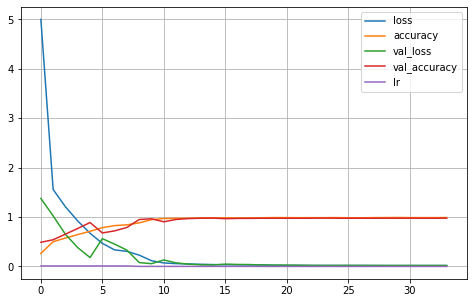

In [20]:
#get all the data and plot it
#history.history dictionary containing loss and any extra metrics 
#history.params training parameters
#history.epoch list of epochs
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.show()

#4) Encoder-Decoder for inference

Model: "functional_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 1, 300)       1614300     input_3[0][0]                    
__________________________________________________________________________________________________
encoder_hidden_state (InputLaye [(None, 1024)]       0                                            
__________________________________________________________________________________________________
decoder_gru (GRU)               multiple             4073472     embedding_4[0][0]                
                                                                 encoder_hidden_state[0

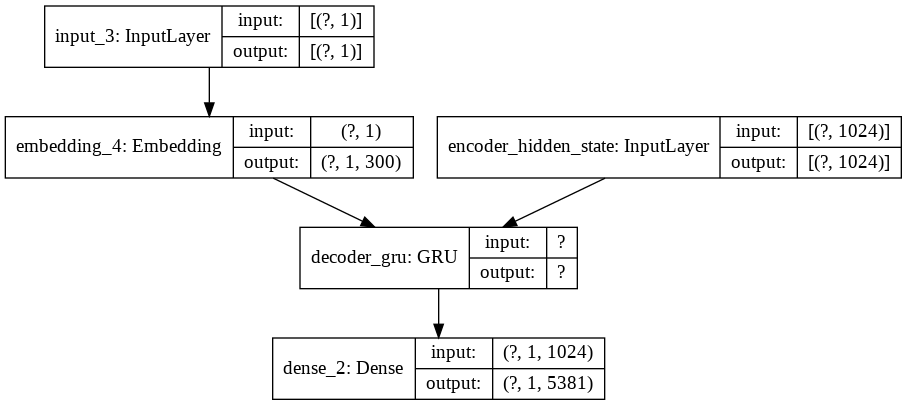

In [21]:
##############Model modified for INFERENCE##################

# encoder_model_inference is the same as in training
encoder_inf = Model(encoder_input, state_h)

encoder_inf.save("/content/gdrive/My Drive/tfm/encoder_inf_model_v1.h5")
encoder_inf.save_weights("/content/gdrive/My Drive/tfm/encoder_inf_weights_v1.h5")

# decoder_model_inference
decoder_inf_state_input_h = Input(shape=(nodes, ), name="encoder_hidden_state") #Encoder hidden states

# decoder_inputs
decoder_inf_input = Input(shape=(1,)) #Input fro inference decoding is 1 word at a time
decoder_inf_input_emb = Embedding(en_vocab_size, 300, \
                                  weights=[emb_en], mask_zero=True)(decoder_inf_input)

# decoder
decoder_inf_gru = GRU(nodes, return_sequences=True, unroll=True, return_state=True)
decoder_inf, h_inf = decoder_gru(decoder_inf_input_emb, initial_state=decoder_inf_state_input_h)
decoder_inf_state = h_inf

decoder_inf_output = Dense(en_vocab_size, activation="softmax")(decoder_inf)


decoder_inf_model = Model([decoder_inf_input, decoder_inf_state_input_h], \
                          [decoder_inf_output, decoder_inf_state])

decoder_inf_model.summary()

plot_model(decoder_inf_model, to_file="/content/gdrive/My Drive/tfm/decoder_inf_model_v1.png", \
           show_shapes=True, show_layer_names=True)

decoder_inf_model.save("/content/gdrive/My Drive/tfm/decoder_inf_model_v1.h5")
decoder_inf_model.save_weights("/content/gdrive/My Drive/tfm/decoder_inf_weights_v1.h5")
plot_model(decoder_inf_model, to_file="/content/gdrive/My Drive/tfm/model_inf_v1.png", show_shapes=True)

#5 Inference Loop

In [22]:
#Reverse dictionary integer-word

decoding_dict = {v: k for k, v in en_tokenizer_lang.word_index.items()}

decode_zh = {v: k for k, v in zh_tokenizer_lang.word_index.items()}
decode_en = {v: k for k, v in en_tokenizer_lang.word_index.items()}

In [23]:
def translate_sentence(input_sentence, target_tokenizer, decoding_dict, output_max_len):
    states_value = encoder_inf.predict(input_sentence)

    target_sequence = np.zeros((1, 1))
    target_sequence[0, 0] = target_tokenizer.word_index.get("<start>")
    end_of_sequence = target_tokenizer.word_index.get("<end>")

    translated_sentence = []

    for i in range(output_max_len):
        output_token, decoder_states = decoder_inf_model.predict([target_sequence, states_value])
        id_word = np.argmax(output_token[0, 0, :])

        if id_word == end_of_sequence or input_sentence[0][i] == 0:  #this is wrong so far
            break

        decoded_word = ""

        if id_word > 0:
            decoded_word = decoding_dict.get(id_word)
            translated_sentence.append(decoded_word)

        target_sequence[0, 0] = id_word
        states_value = decoder_states

    return " ".join(translated_sentence)

#6) Evaluate model

In [82]:
def translate_corpus(corpus, tokenizer, decoding_dict, output_max_len):
    corpus_list = list()
    for i in range(0, len(corpus)):
        line = translate_sentence(corpus[i:i + 1], tokenizer, decoding_dict, output_max_len)
        corpus_list.append(line)
    return corpus_list

In [83]:
#######Model Evaluation######3
decode_zh = {v: k for k, v in zh_tokenizer_lang.word_index.items()}
decode_en = {v: k for k, v in en_tokenizer_lang.word_index.items()}

decode_zh.update({0: "0"})
decode_en.update({0: "0"})

In [84]:
def decode_source(sentence):
    sent = np.ndarray.tolist(sentence)
    words = [decode_zh.get(letter) for letter in sent]
    my_texts = (["".join(words[i]) for i in range(len(words))])
    text = [i for i in my_texts if i != "0"]
    return text


def decode_target(sentence):
    sent = np.ndarray.tolist(sentence)
    words = [decode_en.get(letter) for letter in sent]
    my_texts = (["".join(words[i]) for i in range(len(words))])
    text = [i for i in my_texts if i != "0"]
    return text


In [89]:
# tokenizer = en_tokenizer_lang
# output_max_len = global_max_len
# decoding_dict = decode_zh
def evaluate_model(source_corpus, target_corpus):
    original = source_corpus   #format: list of sentences as words
    actual = [decode_target(target_corpus[i]) for i in
              range(len(target_corpus))] #format: list of sentence as tokens
    predicted = translate_corpus(source_corpus, en_tokenizer_lang, \
                                 decoding_dict=decode_en, output_max_len=global_max_len)

    print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
    print('BLEU-2: %f' % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
    print('BLEU-3: %f' % corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0)))
    print('BLEU-4: %f' % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))

In [91]:
#We should get some validation data apart, but this shows how the function should be used
c = zh_word_tensor[0:1000]
p = en_word_tensor[0:1000]
evaluacion = evaluate_model(c, p)

BLEU-1: 0.291640
BLEU-2: 0.126643
BLEU-3: 0.060967
BLEU-4: 0.014691


Even though the loss is minimal, so the model is likely overfitting, BLEU scores are rather low. Also, predictions are far from accurate. 

Thoughs on why this may be: 

1) Sequences too long
2) Number of tokens to be predicted to high

3) Insufficient data

4) Differences between the languages too big to be captured by the model